This notebook provides a very short and high level introduction to feature engineering and exploratory data analysis (EDA). 
The agenda for this 1 hour bootcamp includes:

1. A TED talk on EDA, features, and machine learning (15 min talk)
2. Exploratory data analysis
3. Feature engineering
4. Unsupervised learning

First we load our dependencies.

In [1]:
import pandas as pd
import numpy as np
import sklearn
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Next we load our data

In [2]:
def clean_cols(df):
    df.columns = (df.columns
        .str.lower()
        .str.replace(".","_")
        .str.replace(" ","")
        .str.replace(":","")
        )
    return df

treatment = pd.read_csv('./data/PerfTreatment_subset.csv').pipe(clean_cols)

well_header = pd.read_csv('./data/WellHeader_subset.csv').pipe(clean_cols)

production = pd.read_csv('./data/WellProduction_subset.csv').pipe(clean_cols)

We need to spread and fix the dates in the production table to make it useable

In [3]:
def multiindex_pivot(df, index=None, columns=None, values=None):
    #https://github.com/pandas-dev/pandas/issues/23955
    if index is None:
        names = list(df.index.names)
        df = df.reset_index()
    else:
        names = index
    list_index = df[names].values
    tuples_index = [tuple(i) for i in list_index] # hashable
    df = df.assign(tuples_index=tuples_index)
    df = df.pivot(index="tuples_index", columns=columns, values=values)
    tuples_index = df.index  # reduced
    index = pd.MultiIndex.from_tuples(tuples_index, names=names)
    df.index = index
    return df

production['date'] = pd.to_datetime(production.prodperiod)

prod_wide = (production
    .drop(['unnamed0','prodperiod','wellheader_match'], axis=1)
    .set_index(['date','epassetsid'])
)

prod_wide = multiindex_pivot(prod_wide, columns='prodtype', values='volume').pipe(clean_cols)

## On EDA, Feature Engineering, and Machine Learning

This section is basically just a very short lecture on a massive subject, 
highly opinionated based on my own experience. I hope to go over what machine 
learning really is, why exploratory data analysis and feature engineering are 
so important for this competition, and then lay out the landscape of machine
learning techniques you might want to explore.

## Exploratory Data Analysis

This section is prompted by questions I might ask when approaching this dataset
in order to prime my brain for doing some feature

In [4]:
# How many wells are in the dataset?
prod_wells = prod_wide.index.get_level_values(1)
print(
    len(set(prod_wells))
    )

print(
    len(set(well_header.epassetsid))
    )

print(
    len(set(well_header.epassetsid).intersection(set(prod_wells)))
    )

1135
1147
1135


In [ ]:
#How long is each lateral well?

In [5]:
surface = gpd.GeoDataFrame(
    well_header, geometry=gpd.points_from_xy(well_header.surf_longitude, well_header.surf_latitude), crs="EPSG:4326")

surface = surface.to_crs(epsg=2956)

bottomhole = gpd.GeoDataFrame(
    well_header, geometry=gpd.points_from_xy(well_header.bh_longitude, well_header.bh_latitude), crs="EPSG:4326")

bottomhole = bottomhole.to_crs(epsg=2956)

well_header['lateral_dist_m'] = surface.geometry.distance(bottomhole.geometry)

Now we have a georeferenced dataframe to do spatial operations on

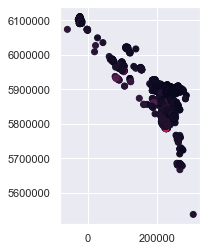

AttributeError: module 'seaborn' has no attribute 'plt'

In [6]:
surface.plot('daysdrilling')
plt.show()

sns.distplot(well_header.lateral_dist_m)
plt.show()

sns.scatterplot(x=well_header.finaldrilldate, y=well_header.lateral_dist_m)
plt.show()

In [172]:
# What's each well's total production?
tmp_prod_wide = prod_wide.copy()
tmp_prod_wide['date'] = tmp_prod_wide.index.get_level_values(0)
tmp_prod_wide.index = tmp_prod_wide.index.droplevel(0)
cum_prod = tmp_prod_wide.groupby(['epassetsid']).sum()
cum_prod.columns = 'cum_'+cum_prod.columns

#Now we can merge that into our well header
well_header = well_header.merge(cum_prod, on='epassetsid')

In [179]:
well_header['drilldate'] = pd.to_datetime(well_header.finaldrilldate)
well_header['drilldelta'] = ((well_header.drilldate - well_header.drilldate.min())/ np.timedelta64(1, 'D')).astype(int)
well_header['prod_drill_slope'] = well_header.cum_productionhours/well_header.drilldelta   

In [ ]:
#Lets now do some correlation analysis
sns.pairplot(well_header[['drilldate','prod_drill_slope','cum_productionhours']])
sns.plt.show()